This is simple mmdetection infrence script as a base line.
Training part can be foud [here](https://www.kaggle.com/its7171/mmdetection-for-segmentation-training).

In [38]:
# !rsync -a ../input/mmdetection-v280/mmdetection ../
# !pip install ../input/mmdetection-v280/src/mmdet-2.8.0/mmdet-2.8.0/
# !pip install ../input/mmdetection-v280/src/mmpycocotools-12.0.3/mmpycocotools-12.0.3/
# !pip install ../input/mmdetection-v280/src/addict-2.4.0-py3-none-any.whl
# !pip install ../input/mmdetection-v280/src/yapf-0.30.0-py2.py3-none-any.whl
# !pip install ../input/mmdetection-v280/src/mmcv_full-1.2.6-cp37-cp37m-manylinux1_x86_64.whl

Processing /kaggle/input/mmdetection-v280/src/mmdet-2.8.0/mmdet-2.8.0
  Created wheel for mmdet: filename=mmdet-2.8.0-py3-none-any.whl size=502141 sha256=c89a4a179166b20c064009b9a8b7ff48566e44688425c0de5a387aa736e9a3e6
  Stored in directory: /root/.cache/pip/wheels/ae/ca/90/3616110259678ffe2ef41fd1470981d081a340886954465c71
Successfully built mmdet
  Attempting uninstall: mmdet
    Found existing installation: mmdet 2.8.0
    Uninstalling mmdet-2.8.0:
      Successfully uninstalled mmdet-2.8.0
Processing /kaggle/input/mmdetection-v280/src/mmpycocotools-12.0.3/mmpycocotools-12.0.3
  Created wheel for mmpycocotools: filename=mmpycocotools-12.0.3-cp37-cp37m-linux_x86_64.whl size=272906 sha256=bbf5dc9ab55040f5bf149ffcda2c83aa5aff710dec44793b232e4da603161ca5
  Stored in directory: /root/.cache/pip/wheels/80/e0/da/3288fdf3965b5c9090f368462db9d28be2c82013f51821090a
Successfully built mmpycocotools
  Attempting uninstall: mmpycocotools
    Found existing installation: mmpycocotools 12.0.3
    

In [39]:
import pandas as pd
import numpy as np
import os
import cv2
from tqdm import tqdm
import pickle
from itertools import groupby
from pycocotools import mask as mutils
from pycocotools import _mask as coco_mask
import matplotlib.pyplot as plt
import os
import base64
import typing as t
import zlib
import random
random.seed(0)

exp_name = "v3"
conf_name = "mask_rcnn_s101_fpn_syncbn-backbone+head_mstrain_1x_coco"
# model_name = 'mask_rcnn_r50_fpn_1x_epoch_12'
ROOT = '../input/hpa-single-cell-image-classification/'
train_or_test = 'test'
df = pd.read_csv(os.path.join(ROOT, 'sample_submission.csv'))

df = df[4:10]


# helper funcs

In [40]:
def read_img(image_id, color, train_or_test='train', image_size=None):
    filename = f'{ROOT}/{train_or_test}/{image_id}_{color}.png'
    assert os.path.exists(filename), f'not found {filename}'
    img = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
    if image_size is not None:
        img = cv2.resize(img, (image_size, image_size))
    if img.dtype == 'uint16':
        img = (img/256).astype('uint8')
    return img

def load_RGBY_image(image_id, train_or_test='train', image_size=None):
    red = read_img(image_id, "red", train_or_test, image_size)
    green = read_img(image_id, "green", train_or_test, image_size)
    blue = read_img(image_id, "blue", train_or_test, image_size)
    # using rgb only here
    #yellow = read_img(image_id, "yellow", train_or_test, image_size)
    stacked_images = np.transpose(np.array([red, green, blue]), (1,2,0))
    return stacked_images

def print_masked_img(image_id, mask):
    img = load_RGBY_image(image_id, train_or_test)
    
    plt.figure(figsize=(15, 15))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Image')
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(mask)
    plt.title('Mask')
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(img)
    plt.imshow(mask, alpha=0.6)
    plt.title('Image + Mask')
    plt.axis('off')
    plt.show()

# generate files for mmdetection

In [41]:
out_image_dir = f'../work/mmdet_{exp_name}_{train_or_test}/'
!mkdir -p {out_image_dir}

annos = []
for idx in tqdm(range(len(df))):
    image_id = df.iloc[idx].ID
    img = load_RGBY_image(image_id, train_or_test)
    
    cv2.imwrite(f'{out_image_dir}/{image_id}.jpg', img)
    ann = {
        'filename': image_id+'.jpg',
        'width': img.shape[1],
        'height': img.shape[0],
        'ann': {
            'bboxes': None,
            'labels': None,
            'masks': None
        }
    }
    annos.append(ann)
    
with open(f'../work/mmdet_{exp_name}_tst.pkl', 'wb') as f:
    pickle.dump(annos, f)

100%|██████████| 6/6 [00:03<00:00,  1.93it/s]


# inference

In [42]:
config = f'configs/hpa_{exp_name}/{conf_name}.py'
# model_file = f'../input/hpa-models/{model_name}.pth'
model_file = f'../input/resnet101-1k/resnet101_1k.pth'
result_pkl = f'../work/{model_name}.pkl'
additional_conf = '--cfg-options'
additional_conf += ' test_cfg.rcnn.score_thr=0.001'
cmd = f'python tools/test.py {config} {model_file} --out {result_pkl} {additional_conf}'
!cd ../mmdetection; {cmd}
result = pickle.load(open('../mmdetection/'+result_pkl, 'rb'))

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 6/6, 0.3 task/s, elapsed: 21s, ETA:     0s
writing results to ../work/mask_rcnn_r50_fpn_1x_epoch_12.pkl


# result check

class_id:0, image_id:0173029a-161d-40ef-af28-2342915b22fb, confidence:0.32930970191955566


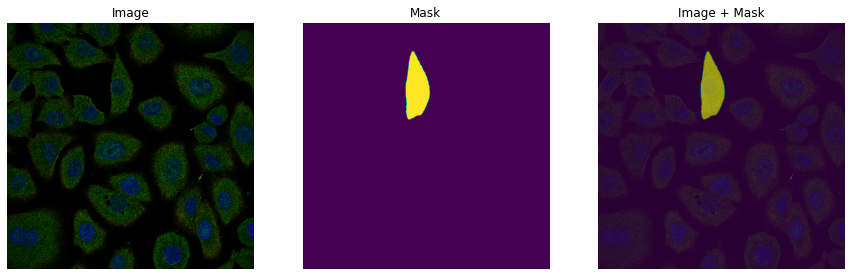

class_id:0, image_id:0173029a-161d-40ef-af28-2342915b22fb, confidence:0.32010072469711304


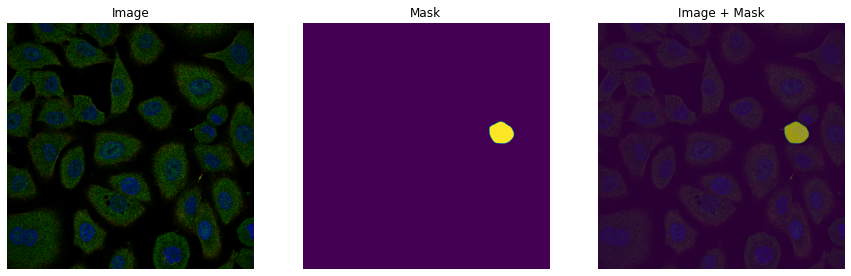

class_id:0, image_id:0173029a-161d-40ef-af28-2342915b22fb, confidence:0.3186004161834717


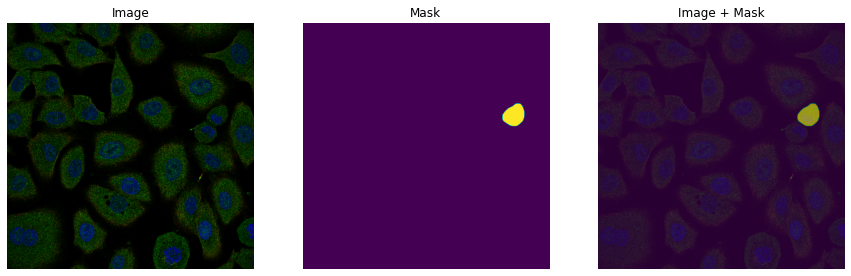

class_id:0, image_id:0173029a-161d-40ef-af28-2342915b22fb, confidence:0.31529366970062256


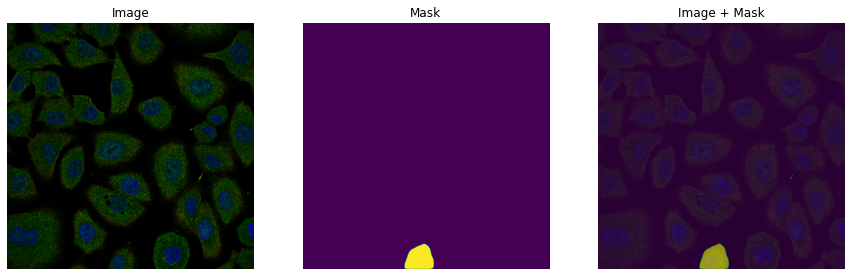

class_id:0, image_id:0173029a-161d-40ef-af28-2342915b22fb, confidence:0.3067028820514679


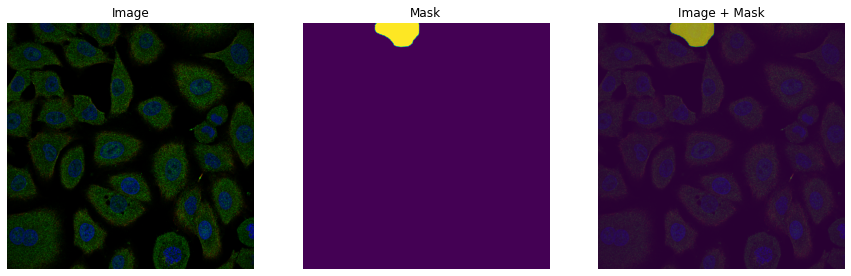

class_id:0, image_id:0173029a-161d-40ef-af28-2342915b22fb, confidence:0.30404114723205566


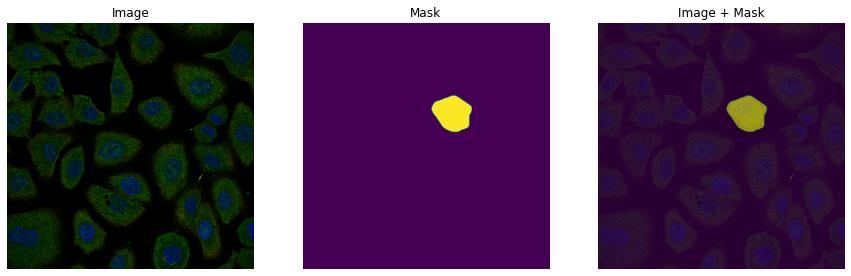

class_id:16, image_id:0173029a-161d-40ef-af28-2342915b22fb, confidence:0.32626497745513916


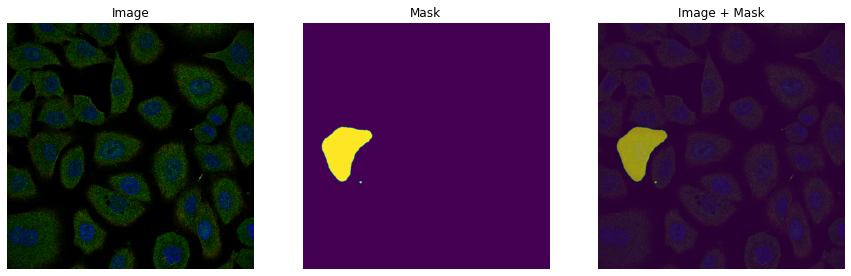

In [43]:
for ii in range(3):
    image_id = annos[ii]['filename'].replace('.jpg','').replace('.png','')
    for class_id in range(19):
        #print(ii,class_id,len(result[ii][0][class_id]), len(result[ii][1][class_id]))
        bbs = result[ii][0][class_id]
        sgs = result[ii][1][class_id]
        for bb, sg in zip(bbs,sgs):
            box = bb[:4]
            cnf = bb[4]
            h = sg['size'][0]
            w = sg['size'][0]
            if cnf > 0.3:
                print(f'class_id:{class_id}, image_id:{image_id}, confidence:{cnf}')
                mask = mutils.decode(sg).astype(bool)
                print_masked_img(image_id, mask)